#### URL for the dataset

In [24]:
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/VDA_Banking_L2/bank-additional.zip

--2025-04-12 11:24:02--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/VDA_Banking_L2/bank-additional.zip
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 444572 (434K) [application/zip]
Saving to: ‘bank-additional.zip.1’

bank-additional.zip 100%[===================>] 434.15K  --.-KB/s    in 0.07s   

2025-04-12 11:24:03 (6.48 MB/s) - ‘bank-additional.zip.1’ saved [444572/444572]



#### Unzipping to a folder. It is a good idea to apply the -o and -q when unzipping to quiet the process and overwrite any existing folders.

In [25]:
!unzip -o -q bank-additional.zip

### Import the libraries necessary to use

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
plt.rcParams["figure.figsize"] = (8, 6)
# Data transformation
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
# Features Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif
# warnings deactivate
import warnings
warnings.filterwarnings('ignore')

#### precision parameter equal to 2 to display two decimal signs (instead of 6 as default).

In [27]:
pd.set_option("display.precision", 2)
pd.options.display.float_format = '{:.2f}'.format

### DataSet preparation

In [28]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep = ';')
# Transform to categorical data
col_cat = list(df.select_dtypes(include=['object']).columns)
df.loc[:, col_cat] = df[col_cat].astype('category')
# Create DataSets
X = df.iloc[:,:-1]  #input columns
y = df.iloc[:,-1]    #target column
# Encoding
col_cat.pop()
oe = OrdinalEncoder()
oe.fit(X[col_cat])
X_cat_enc = oe.transform(X[col_cat])
X_cat_enc = pd.DataFrame(X_cat_enc)
X_cat_enc.columns = col_cat
# Normalization
col_num = list(df.select_dtypes(include =['int64', 'float64']).columns)
scaler = MinMaxScaler(feature_range=(0, 1))
X_num_enc = scaler.fit_transform(X[col_num])
X_num_enc = pd.DataFrame(X_num_enc)
X_num_enc.columns = col_num
x_enc = pd.concat([X_cat_enc, X_num_enc], axis=1)
# Encoding target
le = LabelEncoder()
le.fit(y)
y_enc = le.transform(y)
y_enc = pd.Series(y_enc)
y_enc.columns = y.name
# Remove correlated fields
col = list(x_enc.columns)
col.remove('emp.var.rate')
col.remove('nr.employed')
x_enc = x_enc[col]
# Feature selection
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(x_enc,y_enc)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x_enc.columns)
featureScores = pd.concat([dfcolumns, dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
x_enc = x_enc[list(featureScores.nlargest(10,'Score')['Specs'])]
print(x_enc)
print(y_enc)

       euribor3m  contact  previous  duration  default  education  pdays  \
0           0.96     1.00      0.00      0.05     0.00       0.00   1.00   
1           0.96     1.00      0.00      0.03     1.00       3.00   1.00   
2           0.96     1.00      0.00      0.05     0.00       3.00   1.00   
3           0.96     1.00      0.00      0.03     0.00       1.00   1.00   
4           0.96     1.00      0.00      0.06     0.00       3.00   1.00   
...          ...      ...       ...       ...      ...        ...    ...   
41183       0.09     0.00      0.00      0.07     0.00       5.00   1.00   
41184       0.09     0.00      0.00      0.08     0.00       5.00   1.00   
41185       0.09     0.00      0.00      0.04     0.00       6.00   1.00   
41186       0.09     0.00      0.00      0.09     0.00       5.00   1.00   
41187       0.09     0.00      0.14      0.05     0.00       5.00   1.00   

       poutcome  job  cons.price.idx  
0          1.00 3.00            0.70  
1        

### Classical classification models



In [29]:
#Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [30]:
''' cross-validation combines (averages) measures of fitness in prediction to derive a more accurate estimate of model prediction performance'''
clf = LogisticRegression()
scores = cross_val_score(clf, x_enc, y_enc, scoring='accuracy', cv=5)
print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), 'Logistic Regression'))

Accuracy: 0.87 (+/- 0.06) [Logistic Regression]


In [31]:
clf_name = ['Logistic Regression']
clf_acc = [scores.mean()]

As you can see, accuracy is not bad.

Let's try to use another classificators and compare thair accuracy.

In [32]:
clf1 = LogisticRegression(random_state=1)
clf2 = QuadraticDiscriminantAnalysis()
clf3 = GaussianNB()
clf4 = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
clf5 = AdaBoostClassifier()

for clf, label in zip([clf1, clf2, clf3, clf4, clf5], ['Logistic Regression', 'Quadratic Discriminant Analysis', 'naive Bayes', 'Random Forest', 'Ada Boost']):
     scores = cross_val_score(clf, x_enc, y_enc, scoring='accuracy', cv=5)
     print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.87 (+/- 0.06) [Logistic Regression]
Accuracy: 0.83 (+/- 0.13) [Quadratic Discriminant Analysis]
Accuracy: 0.80 (+/- 0.15) [naive Bayes]
Accuracy: 0.69 (+/- 0.28) [Random Forest]
Accuracy: 0.67 (+/- 0.29) [Ada Boost]


### Ensemble of classical classification models

Voting Classifier is a machine learning model that trains on an ensemble of numerous models and predicts an output (class) based on their highest probability of chosen class as the output.

Hard Voting: In hard voting, the predicted output class is a class with the highest majority of votes.

Soft Voting: In soft voting, the output class is the prediction based on the average of probability given to that class.

In [33]:
eclf = VotingClassifier(
     estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3), ('rfc', clf4), ('abc', clf5)],
     voting='hard')
scores = cross_val_score(eclf, x_enc, y_enc, scoring='accuracy', cv=5)
print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), 'Hard Voiting Ensemble'))

Accuracy: 0.81 (+/- 0.15) [Hard Voiting Ensemble]


In [34]:
clf_name.append('Hard Voiting Ensemble')
clf_acc.append(scores.mean())

In [35]:
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3), ('rfc', clf4), ('abc', clf5)],
     voting='soft', weights=[0.87, 0.83, 0.80, 0.74, 0.61 ])

scores = cross_val_score(eclf, x_enc, y_enc, scoring='accuracy', cv=5)
print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), 'Soft Voiting Ensemble'))

Accuracy: 0.82 (+/- 0.16) [Soft Voiting Ensemble]


In [36]:
clf_name.append('Soft Voiting Ensemble')
clf_acc.append(scores.mean())

### Analysis of errors

In [37]:
X_train, X_test, y_train, y_test = train_test_split(x_enc, y_enc, test_size=0.33, random_state=1)
eclf.fit(X_train, y_train)
yhat = eclf.predict(X_test)

In [38]:
scores_train = eclf.score(X_train, y_train)
scores_test = eclf.score(X_test, y_test)
print('Training DataSet accuracy: {: .1%}'.format(scores_train), 'Test DataSet accuracy: {: .1%}'.format(scores_test))
y_pred = eclf.predict(X_test)  # Get model predictions
cm = confusion_matrix(y_test, y_pred)
print(cm)
plt.show()

Training DataSet accuracy:  89.8% Test DataSet accuracy:  89.9%
[[11621   428]
 [  943   601]]


### Classification with Keras

Input Layer: This is where the training observations are fed. The number of predictor variables is also specified here through the neurons.

Hidden Layers: These are the intermediate layers between the input and output layers. The deep neural network learns about the relationships involved in data in this component.In our cases hidden layer will have 20 neurons.

Output Layer: This is the layer where the final output is extracted from what’s happening in the previous two layers. In case of classification problems, the output layer will have two neuron because 2 classes.

In [39]:
!pip install scikeras
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.utils import to_categorical

# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(20, input_dim=10, activation='relu'))
    model.add(Dense(2, activation='softmax'))  # Output layer with 2 units for 2 classes
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model




In [40]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=10, batch_size=5, verbose=1)
# Convert y_train to one-hot encoding using to_categorical
history = estimator.fit(X_train, to_categorical(y_train))

Epoch 1/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 44s 8ms/step - accuracy: 0.8921 - loss: 0.3032
Epoch 2/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 53s 2ms/step - accuracy: 0.9074 - loss: 0.2296
Epoch 3/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9108 - loss: 0.2203
Epoch 4/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.9082 - loss: 0.2188
Epoch 5/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9088 - loss: 0.2157
Epoch 6/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9095 - loss: 0.2104
Epoch 7/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9067 - loss: 0.2115
Epoch 8/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9064 - loss: 0.2121
Epoch 9/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9052 - loss: 0.2119
Epoch 10/10
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9063 - loss: 0.2082


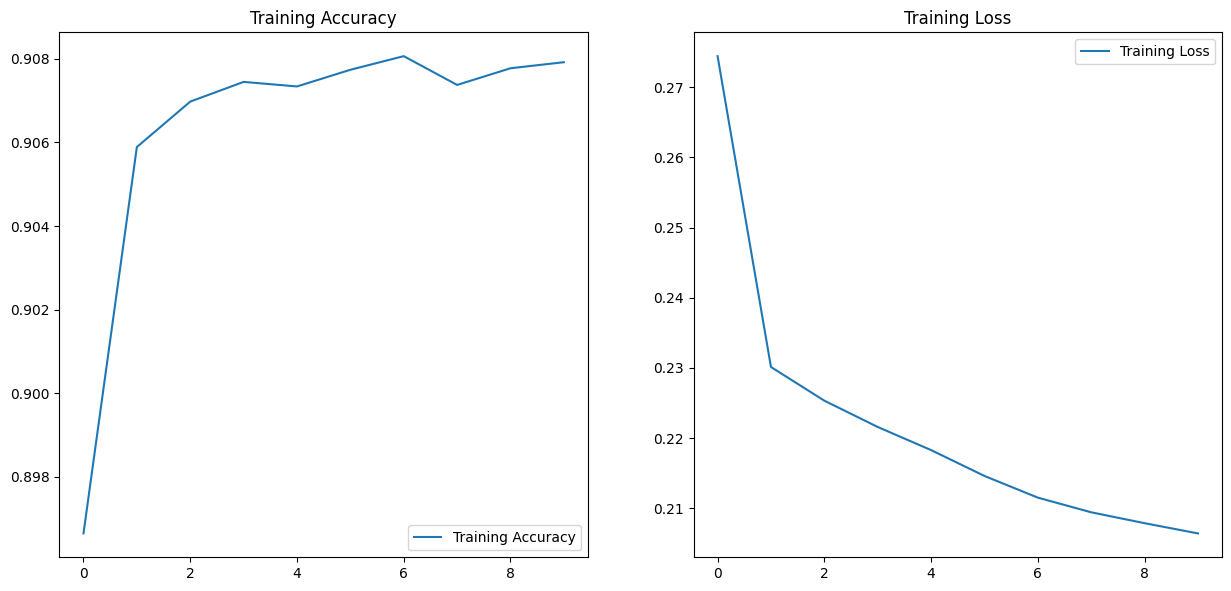

In [41]:
acc = estimator.history_['accuracy']
loss = estimator.history_['loss']

epochs_range = range(10)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

In [42]:
from sklearn.metrics import accuracy_score

In [43]:
yhat = estimator.predict(X_test)
# Convert yhat to binary labels
yhat = np.argmax(yhat, axis=1) # Get the index of the highest probability
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy))

2719/2719 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
Accuracy: 0.91


In [44]:
clf_name.append('KerasClassifier')
clf_acc.append(accuracy)